https://www.kaggle.com/datasets/ayuraj/asl-dataset

In [33]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## LOAD AND PREPROCESS THE DATA

In [92]:
# Define dataset directory
dataset_dir = r"D:/sign_language/asl_dataset/asl_dataset"

# Extract frames and labels
images = []
labels = []

for label_dir in os.listdir(dataset_dir):
    label_path = os.path.join(dataset_dir, label_dir)
    if os.path.isdir(label_path):
        for image_file in os.listdir(label_path):
            if image_file.endswith('.jpeg') or image_file.endswith('.jpg'):
                image_path = os.path.join(label_path, image_file)
                img = cv2.imread(image_path)
                if img is not None:
                    img = cv2.resize(img, (64, 64))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    images.append(img)

                    labels.append(label_dir)

# Ensure images and labels are not empty
images = np.array(images).astype('float32') / 255.0
images = images.reshape(images.shape[0], 64, 64, 1) 
labels = np.array(labels)

print(f"Number of labels: {len(np.unique(labels))}")
print(f"Images shape: {images.shape}")


Number of labels: 36
Images shape: (2515, 64, 64, 1)


In [39]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
np.save('label_classes.npy', label_encoder.classes_)  # Save encoded classes
labels_encoded = tf.keras.utils.to_categorical(labels_encoded)
print("Label Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

# Show the encoded labels for the dataset
print("\nEncoded Labels:")
print(labels_encoded)

Label Mapping:
0 -> 0
1 -> 1
2 -> 2
3 -> 3
4 -> 4
5 -> 5
6 -> 6
7 -> 7
8 -> 8
9 -> 9
a -> 10
b -> 11
c -> 12
d -> 13
e -> 14
f -> 15
g -> 16
h -> 17
i -> 18
j -> 19
k -> 20
l -> 21
m -> 22
n -> 23
o -> 24
p -> 25
q -> 26
r -> 27
s -> 28
t -> 29
u -> 30
v -> 31
w -> 32
x -> 33
y -> 34
z -> 35

Encoded Labels:
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [41]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

## DATA AUGMENTATION

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,  # Increased rotation range
    width_shift_range=0.2,  # Increased shift range
    height_shift_range=0.2,  # Increased shift range
    brightness_range=[0.7, 1.3],  # Changed brightness range
    zoom_range=0.2,  # Increased zoom range
    shear_range=0.2,  # Added shear range
    horizontal_flip=True  # Added horizontal flip
)

## MODEL ARCHITECTURE

In [45]:
# Define the model architecture
model = Sequential([
    Input(shape=(64, 64, 1)),  # Keep input shape the same
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),  # Added another fully connected layer
    Dropout(0.4),  # Added another dropout layer with a slightly lower rate
    Dense(labels_encoded.shape[1], activation='softmax')  # Output layer for classification
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,732 (6.28 MB)

 Trainable params: 1,645,732 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

## COMPILE THE MODEL

In [47]:
from tensorflow.keras.optimizers import Adam 
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## TRAIN THE MODEL

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7924 - loss: 0.5931 - val_accuracy: 0.9324 - val_loss: 0.2317
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7952 - loss: 0.6160 - val_accuracy: 0.9364 - val_loss: 0.2222
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8134 - loss: 0.5692 - val_accuracy: 0.9344 - val_loss: 0.2316
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8369 - loss: 0.5023 - val_accuracy: 0.9344 - val_loss: 0.2191
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8101 - loss: 0.5792 - val_accuracy: 0.9245 - val_loss: 0.2296
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8226 - loss: 0.5082 - val_accuracy: 0.9404 - val_loss: 0.2149
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8194 - loss: 0.5383 - val_accuracy: 0.9423 - val_loss: 0.2060
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8328 - loss: 0.4559 - val_accuracy: 0.9404 - v

## EVALUATE THE MODEL

In [55]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9764 - loss: 0.0939
Test Accuracy: 96.02%


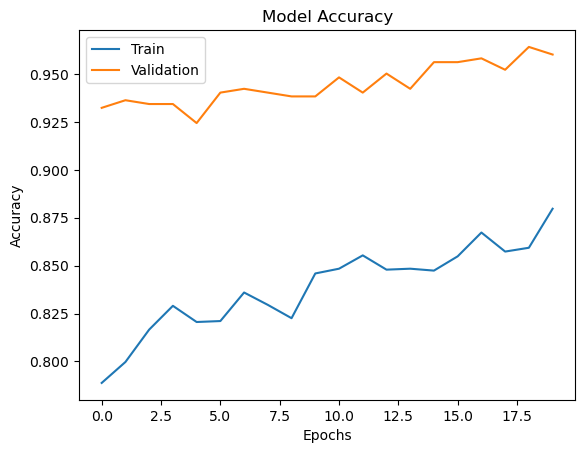

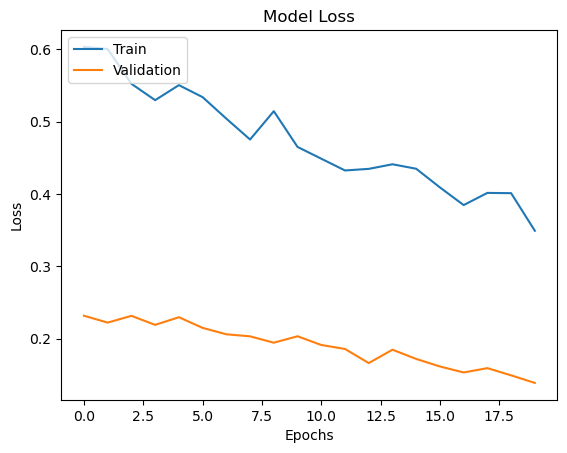

In [57]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## CONFUSION MATRIX

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


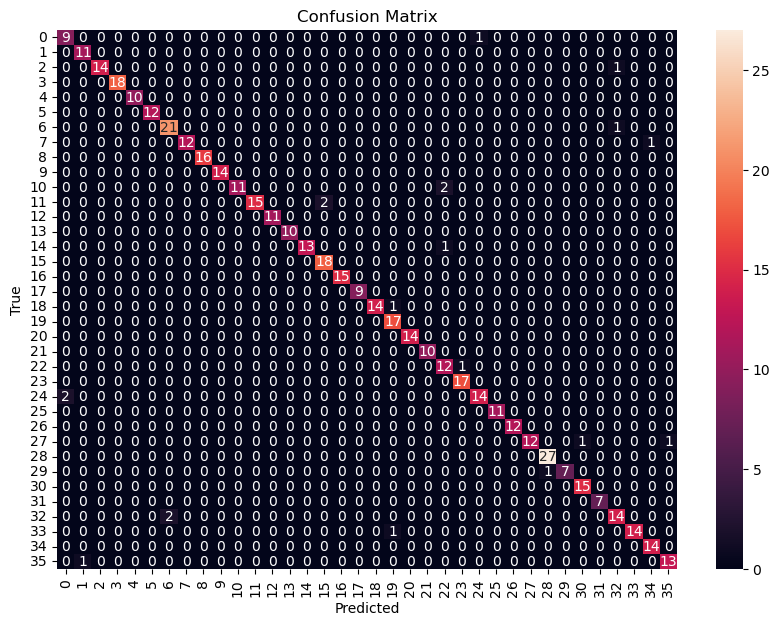

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.92      1.00      0.96        11
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        12
           6       0.91      0.95      0.93        22
           7       1.00      0.92      0.96        13
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        14
           a       1.00      0.85      0.92        13
           b       1.00      0.88      0.94        17
           c       1.00      1.00      1.00        11
           d       1.00      1.00      1.00        10
           e       1.00      0.93      0.96        14
           f       0.90      1.00      0.95        18
           g       1.00      1.00      1.00        15
           h       1.00    

In [59]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))


In [62]:
# Save model weights
model.save_weights('asl_model_weights.weights.h5')

# Load the trained model for real-time testing
model.load_weights('asl_model_weights.weights.h5')
model.save('asl_model_complete.h5')

## REAL TIME TESTING THROUGH WEBCAM

In [101]:
# Initialize video capture and background subtractor
cap = cv2.VideoCapture(0)
background_subtractor = cv2.createBackgroundSubtractorMOG2()

# Fixed size and position for the bounding box
fixed_width = 200
fixed_height = 200
top_left_x = 100  # X position of the top-left corner
top_left_y = 100  # Y position of the top-left corner

def preprocess_image(image):
    # Resize the image to 64x64 and convert it to grayscale (if needed)
    image_resized = cv2.resize(image, (64, 64))  # Resize to model input size (64x64)
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if needed
    image_resized = image_gray.astype('float32') / 255.0  # Normalize the image
    return image_resized

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Define Region of Interest (ROI) based on the fixed bounding box coordinates
    roi = frame[top_left_y:top_left_y+fixed_height, top_left_x:top_left_x+fixed_width]

    # Apply background subtraction and skin segmentation
    fg_mask = background_subtractor.apply(roi)
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    skin_mask = cv2.inRange(hsv_roi, (0, 30, 60), (20, 150, 255))  # Skin segmentation in HSV

    # Combine background subtraction and skin mask
    combined_mask = cv2.bitwise_and(fg_mask, fg_mask, mask=skin_mask)

    # Find contours to visualize detected regions)
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the fixed-size bounding box on the frame
    cv2.rectangle(frame, (top_left_x, top_left_y), 
                  (top_left_x + fixed_width, top_left_y + fixed_height), 
                  (0, 255, 0), 2)  # Fixed bounding box

    # Preprocess the ROI for prediction (inside the fixed bounding box)
    processed_img = preprocess_image(roi)

    # Make prediction
    predictions = model.predict(processed_img.reshape(1, 64, 64, 1), verbose=0)  # Assuming grayscale image
    predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])

    # Display prediction text on the frame
    cv2.putText(frame, f'Prediction: {predicted_label[0]}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the result with the bounding box and prediction
    cv2.imshow('Sign Language Recognition', frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

